Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training samples: 2686 Testing samples: 664


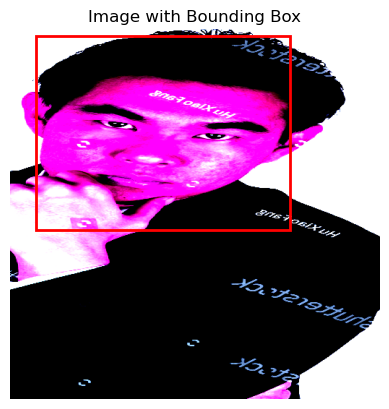

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


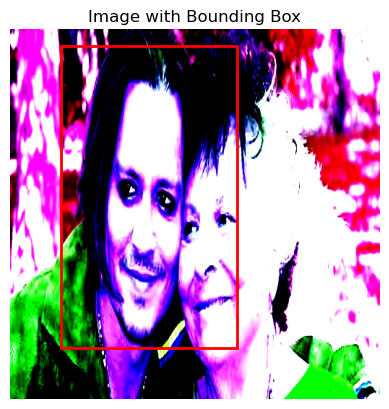

In [7]:
import pandas as pd
import numpy as np
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Load the CSV file
bbox_data = pd.read_csv('data/faces.csv')

# Get the unique image names - since each image may have multiple bounding boxes, we need to get the unique image names
image_names = bbox_data['image_name'].unique()

# Split the data into training and testing sets
train_images, test_images = train_test_split(image_names, test_size=0.2, random_state=42)

# Create DataFrames for training and testing
train_df = bbox_data[bbox_data['image_name'].isin(train_images)]
test_df = bbox_data[bbox_data['image_name'].isin(test_images)]

print("Training samples:", len(train_df), "Testing samples:", len(test_df))

class FacesDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

        # Get list of unique image names
        self.image_names = self.dataframe['image_name'].unique()

        # Group bounding boxes by image name
        self.groups = self.dataframe.groupby('image_name')

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, image_name)
        image = np.array(Image.open(img_path).convert("RGB"))

        # Get bounding boxes
        records = self.groups.get_group(image_name)
        boxes = records[['x0', 'y0', 'x1', 'y1']].values

        # Select the first bounding box (assuming at least one exists)
        boxes = boxes[0]  # Shape: [4]

        # Apply transformations
        sample = {
            'image': image,
            'bboxes': [boxes],  # Albumentations expects a list of bboxes
            'labels': [0]  # Dummy labels for albumentations lib
        }

        if self.transform:
            sample = self.transform(**sample)

        # Convert to tensors
        image = sample['image']
        boxes = torch.tensor(sample['bboxes'][0])  # Shape: [4]

        return image, boxes

# Random Affine transformation 
transform = A.Compose([
    A.RandomSizedBBoxSafeCrop(width=512, height=512, erosion_rate=0.2, p=1.0),  # Ensure all images are cropped and resized to 512x512
    A.HorizontalFlip(p=0.4),
    A.ColorJitter(p=0.42),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])) # to take care of bounding boxes


train_dataset = FacesDataset(train_df, image_dir='data/images', transform=transform)
test_dataset = FacesDataset(test_df, image_dir='data/images', transform=transform)

def display_image_with_bboxes(image, bbox, title="Image with Bounding Box"):
    # Convert tensor image to NumPy array
    image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot bounding box
    x0, y0, x1, y1 = bbox
    rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize two samples to ensure random and consistent augmentations
for _ in range(2):
    idx = random.randint(0, len(train_dataset) - 1)
    image, bbox = train_dataset[idx]
    display_image_with_bboxes(image, bbox)


In [8]:
# Section 1.2: Object Detection with Pre-trained Feature Extractor

import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from torchvision.models import ResNet50_Weights

# Load pre-trained ResNet-50 model using the updated 'weights' parameter
backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze backbone weights
for param in backbone.parameters():
    param.requires_grad = False

class ObjectDetectionModel(nn.Module):
    def __init__(self, backbone):
        super(ObjectDetectionModel, self).__init__()
        self.backbone = backbone
        self.backbone.fc = nn.Identity()  # Remove the original classification head
        self.regressor = nn.Linear(2048, 4)  # New regression head for bounding boxes

    def forward(self, x):
        features = self.backbone(x)
        bbox_preds = self.regressor(features)
        return bbox_preds

# Instantiate the model
model = ObjectDetectionModel(backbone)

# Prepare DataLoader
import os
from torch.utils.data import DataLoader

num_workers = 0  # Set to 0 to avoid the FacesDataset error in Jupyter - could be parallelized in a script

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=True)

# Define loss function and optimizer
criterion = nn.SmoothL1Loss()  # Also known as Huber loss
optimizer = torch.optim.Adam(model.regressor.parameters(), lr=1e-3)

# Determine the device - because I am thinking of either running on my mac or the cloud nodes

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model.to(device)

# Integrate mixed precision training if using CUDA
use_amp = torch.cuda.is_available()

if use_amp:
    scaler = torch.cuda.amp.GradScaler()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, targets in progress_bar:
        images = images.to(device)
        targets = targets.to(device)  # Shape: [batch_size, 4]

        optimizer.zero_grad()
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(images)  # Shape: [batch_size, 4]
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")


Epoch 1/10: 100%|██████████| 111/111 [01:09<00:00,  1.61batch/s, loss=200]


Epoch [1/10], Average Loss: 214.0433


Epoch 2/10: 100%|██████████| 111/111 [01:03<00:00,  1.74batch/s, loss=187]


Epoch [2/10], Average Loss: 194.8303


Epoch 3/10: 100%|██████████| 111/111 [01:04<00:00,  1.73batch/s, loss=200]


Epoch [3/10], Average Loss: 181.5974


Epoch 4/10: 100%|██████████| 111/111 [01:04<00:00,  1.73batch/s, loss=180]


Epoch [4/10], Average Loss: 168.7857


Epoch 5/10: 100%|██████████| 111/111 [01:05<00:00,  1.70batch/s, loss=194]


Epoch [5/10], Average Loss: 154.8154


Epoch 6/10: 100%|██████████| 111/111 [01:04<00:00,  1.72batch/s, loss=165]


Epoch [6/10], Average Loss: 144.2830


Epoch 7/10: 100%|██████████| 111/111 [01:03<00:00,  1.73batch/s, loss=106] 


Epoch [7/10], Average Loss: 134.3317


Epoch 8/10: 100%|██████████| 111/111 [01:04<00:00,  1.73batch/s, loss=132]


Epoch [8/10], Average Loss: 123.2475


Epoch 9/10: 100%|██████████| 111/111 [01:04<00:00,  1.72batch/s, loss=109] 


Epoch [9/10], Average Loss: 116.5842


Epoch 10/10: 100%|██████████| 111/111 [01:04<00:00,  1.73batch/s, loss=119] 

Epoch [10/10], Average Loss: 108.4292


Evaluating: 100%|██████████| 28/28 [00:14<00:00,  1.88batch/s]


Mean IoU on test set: 0.1088


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


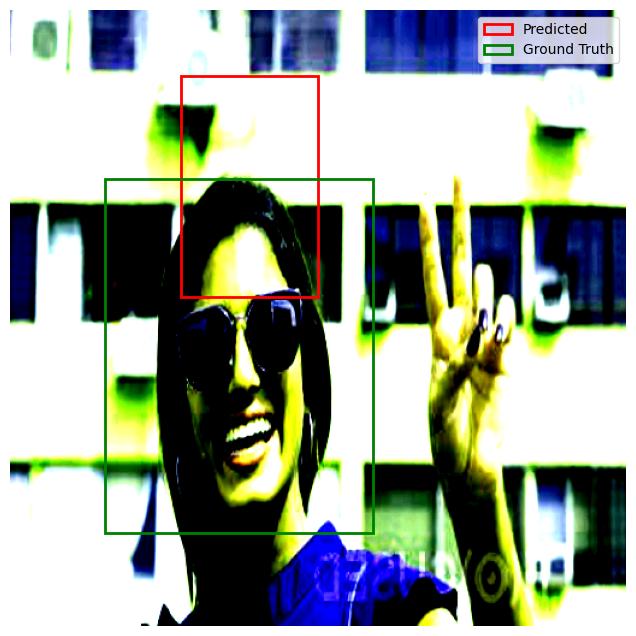

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


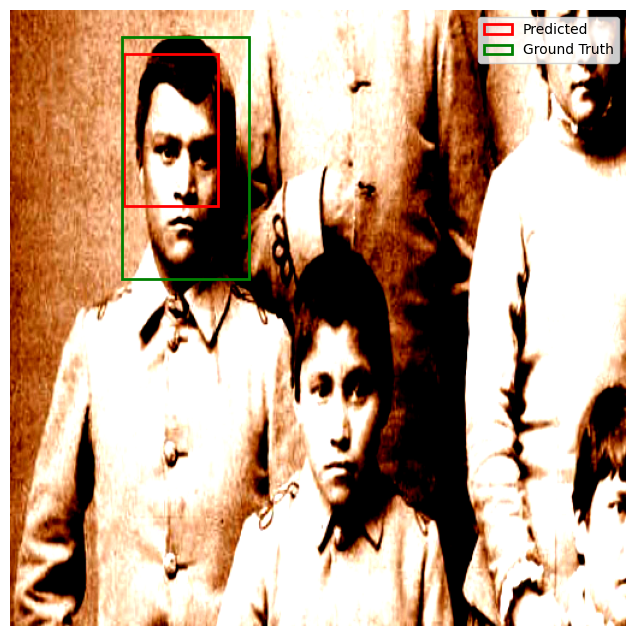

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


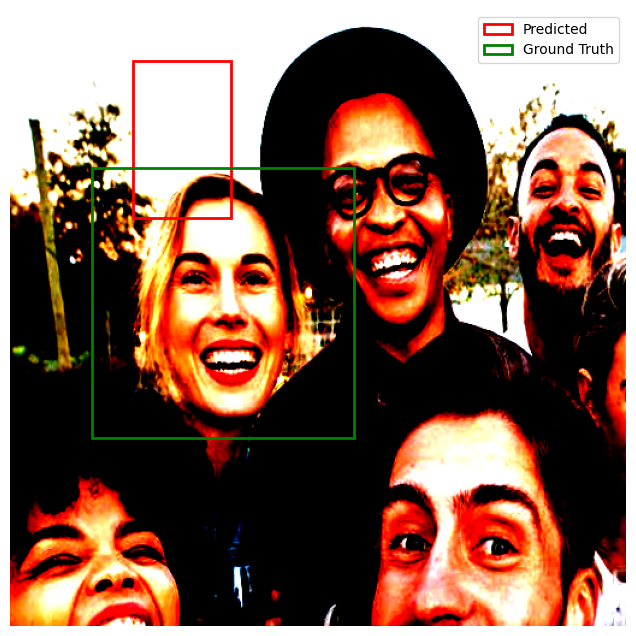

In [9]:
# Evaluation using IoU

def compute_iou(box1, box2):
    """
    Computes IoU between two sets of boxes.
    box1: Tensor of shape [N, 4]
    box2: Tensor of shape [N, 4]
    Returns IoU: Tensor of shape [N]
    """
    xA = torch.max(box1[:, 0], box2[:, 0])
    yA = torch.max(box1[:, 1], box2[:, 1])
    xB = torch.min(box1[:, 2], box2[:, 2])
    yB = torch.min(box1[:, 3], box2[:, 3])

    interWidth = (xB - xA).clamp(min=0)
    interHeight = (yB - yA).clamp(min=0)
    interArea = interWidth * interHeight

    box1Area = (box1[:, 2] - box1[:, 0]).clamp(min=0) * (box1[:, 3] - box1[:, 1]).clamp(min=0)
    box2Area = (box2[:, 2] - box2[:, 0]).clamp(min=0) * (box2[:, 3] - box2[:, 1]).clamp(min=0)

    iou = interArea / (box1Area + box2Area - interArea + 1e-6)
    return iou

model.eval()
with torch.no_grad():
    total_iou = 0
    count = 0
    progress_bar = tqdm(test_loader, desc="Evaluating", unit="batch")
    for images, targets in progress_bar:
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)  # Shape: [batch_size, 4]

        # Clamp the outputs to positive values
        outputs = outputs.clamp(min=0)

        ious = compute_iou(outputs, targets)
        total_iou += ious.sum().item()
        count += len(ious)

    mean_iou = total_iou / count
    print(f"Mean IoU on test set: {mean_iou:.4f}")

# Visualization of Predictions

def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        for _ in range(num_samples):
            idx = random.randint(0, len(dataset) - 1)
            image, target = dataset[idx]
            image_input = image.unsqueeze(0).to(device)  # Add batch dimension
            output = model(image_input)
            output = output.squeeze(0).cpu()

            # Clamp the output to image dimensions if necessary
            output = output.clamp(min=0)

            # Display the image with predicted and ground truth bounding boxes
            image_np = image.permute(1, 2, 0).cpu().numpy()
            fig, ax = plt.subplots(1, figsize=(8, 8))
            ax.imshow(image_np)

            # Predicted bounding box (red)
            x0, y0, x1, y1 = output
            rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
            ax.add_patch(rect)

            # Ground truth bounding box (green)
            x0_gt, y0_gt, x1_gt, y1_gt = target
            rect_gt = patches.Rectangle((x0_gt, y0_gt), x1_gt - x0_gt, y1_gt - y0_gt, linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
            ax.add_patch(rect_gt)

            plt.legend()
            plt.axis('off')
            plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, device, num_samples=3)


# 1. 3

In [12]:
# Unfreeze all layers in the backbone
for param in backbone.parameters():
    param.requires_grad = True

# Update the optimizer to include all parameters with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning


In [13]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, targets in progress_bar:
        images = images.to(device)
        targets = targets.to(device)  # Shape: [batch_size, 4]

        optimizer.zero_grad()
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(images)  # Shape: [batch_size, 4]
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")


Epoch 1/10: 100%|██████████| 111/111 [02:44<00:00,  1.48s/batch, loss=65.2]


Epoch [1/10], Average Loss: 75.8359


Epoch 2/10: 100%|██████████| 111/111 [02:36<00:00,  1.41s/batch, loss=75]  


Epoch [2/10], Average Loss: 68.7967


Epoch 3/10: 100%|██████████| 111/111 [03:36<00:00,  1.95s/batch, loss=92.2]


Epoch [3/10], Average Loss: 67.4100


Epoch 4/10: 100%|██████████| 111/111 [04:39<00:00,  2.51s/batch, loss=67.7]


Epoch [4/10], Average Loss: 65.8574


Epoch 5/10: 100%|██████████| 111/111 [02:32<00:00,  1.38s/batch, loss=81.2]


Epoch [5/10], Average Loss: 63.8863


Epoch 6/10: 100%|██████████| 111/111 [02:38<00:00,  1.43s/batch, loss=39.3]


Epoch [6/10], Average Loss: 62.5398


Epoch 7/10: 100%|██████████| 111/111 [02:41<00:00,  1.45s/batch, loss=95.2]


Epoch [7/10], Average Loss: 60.7554


Epoch 8/10: 100%|██████████| 111/111 [02:40<00:00,  1.45s/batch, loss=58.3]


Epoch [8/10], Average Loss: 60.0319


Epoch 9/10: 100%|██████████| 111/111 [02:37<00:00,  1.42s/batch, loss=74]  


Epoch [9/10], Average Loss: 59.0284


Epoch 10/10: 100%|██████████| 111/111 [02:43<00:00,  1.47s/batch, loss=51.6]

Epoch [10/10], Average Loss: 56.8998


In [14]:
model.eval()
with torch.no_grad():
    total_iou = 0
    count = 0
    for images, targets in test_loader:
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)

        # Clamp the outputs to image size if necessary
        outputs = outputs.clamp(min=0)

        ious = compute_iou(outputs, targets)
        total_iou += ious.sum().item()
        count += len(ious)

    mean_iou = total_iou / count
    print(f"Mean IoU on test set after fine-tuning: {mean_iou:.4f}")


Mean IoU on test set after fine-tuning: 0.4276


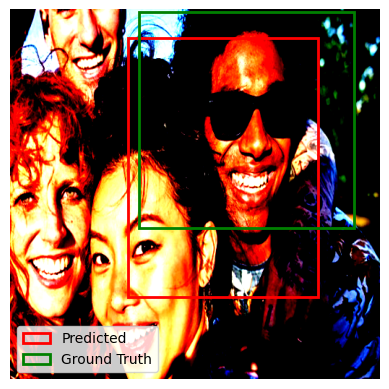

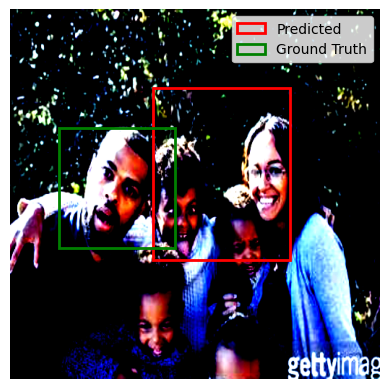

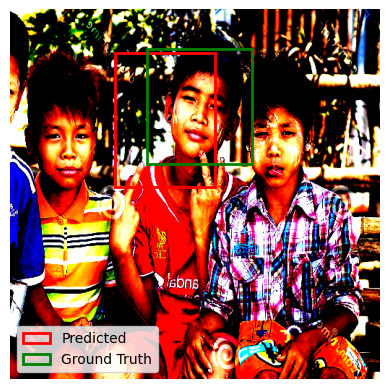

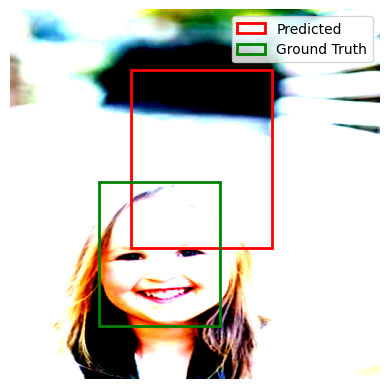

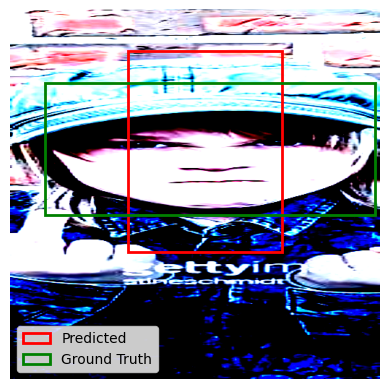

In [16]:
with torch.no_grad():
    for _ in range(5):
        idx = random.randint(0, len(test_dataset) - 1)
        image, target = test_dataset[idx]
        image_input = image.unsqueeze(0).to(device)  # Add batch dimension
        output = model(image_input)
        output = output.squeeze(0).cpu()

        # Clamp the output to image dimensions
        output = output.clamp(min=0)

        # Display the image with predicted and ground truth bounding boxes
        image_np = image.permute(1, 2, 0).cpu().numpy()
        fig, ax = plt.subplots(1)
        ax.imshow(np.clip(image_np, 0, 1))

        # Predicted bounding box (red)
        x0, y0, x1, y1 = output
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
        ax.add_patch(rect)

        # Ground truth bounding box (green)
        x0_gt, y0_gt, x1_gt, y1_gt = target
        rect_gt = patches.Rectangle((x0_gt, y0_gt), x1_gt - x0_gt, y1_gt - y0_gt, linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
        ax.add_patch(rect_gt)

        plt.legend()
        plt.axis('off')
        plt.show()
